In [1]:
import os
import sys
import json

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import pypsa

data_dir = os.path.abspath("data")
from IPython.display import clear_output

In [2]:
from utils.data_ingestion_load_data import (
    load_main_data,
    build_data_columns,
    set_muni_index,
)
from utils.japan_area_names import cities_jp_to_en, prefecture_dict_jp_to_en
from utils.fig_handler import init_savefig, HandlerValue
from utils.jp_map_processor import cities_list_en as cities_list
from utils.downloader import download_file, unzip_file

In [3]:
print(pypsa.__version__)

0.26.2


In [4]:
# load config
if os.path.exists("config.json"):
    with open("config.json") as config_file:
        config = json.load(config_file)
else:
    config = dict()

# set the save parameters
save_flag = bool(config.get("save_fig_flag", False))
base_folder = config.get("save_fig_loc", None)
savefig = init_savefig(save_flag, base_folder)

# set the RUN_ID and scenario_base_folder. This is used to load the results.
RUN_ID = config.get("RUN_ID")
results_folder = os.path.join(data_dir, "pypsa-results")
scenario_base_folder = os.path.join(results_folder, RUN_ID)
print("RUN_ID:", RUN_ID)
print("Results Base Folder:", scenario_base_folder)

# download the complementary files if the results folder does not exist
if not os.path.exists(scenario_base_folder):
	print("Downloading and extracting results files.")
	zenodo_url = config.get("results_zenodo_url")
	zip_file = os.path.join(results_folder, f"{RUN_ID}.zip")
	download_file(zenodo_url, zip_file)
	extract_folder = os.path.join(results_folder, RUN_ID)
	unzip_file(zip_file, extract_folder)

RUN_ID: published-ver
Results Base Folder: /home/matthew/GitHub/esm-jp-major-cities-rpv-potential/data/pypsa-results/published-ver


In [5]:
# ============================================================================ #
# Load results
# ============================================================================ #

n_dict = dict()
for muni_name in cities_list:
    for has_battery in [False, True]:
        for pv_level in [1, 2, 3]:
            folder_name = f"{muni_name.lower()}_{int(has_battery)}_{pv_level}"
            save_network_folder = os.path.join(scenario_base_folder, folder_name)
            print(folder_name)

            if os.path.exists(save_network_folder):
                n_dict[folder_name] = pypsa.Network()
                n_dict[folder_name].import_from_csv_folder(save_network_folder)

    clear_output(wait=True)
clear_output(wait=True)

if len(n_dict) == 126:
    print("Successfully loaded all scenarios for the 21 major cities.")
else:
    print("Some file are missing. Please check the results files.")

Successfully loaded all scenarios for the 21 major cities.


In [6]:
# ============================================================================ #
# # extract demand
# ============================================================================ #

municipal_demand = dict()

for muni_name in cities_list:
	has_battery = False
	pv_level = 1
	folder_name = f"{muni_name.lower()}_{int(has_battery)}_{pv_level}"

	muni_load_x = n_dict[folder_name].loads_t.p['residential'].sum()/1_000 # MWh
	municipal_demand[muni_name] = muni_load_x

municipal_demand = pd.DataFrame.from_dict(municipal_demand, orient='index', columns=['demand'])
municipal_demand.div(1_000_000)

,demand
Sapporo,3.144661
Sendai,1.814143
Saitama,1.913063
Chiba,1.294940
Yokohama,5.462224
Kawasaki,3.648136
Sagamihara,1.199252
Niigata,1.106256
Shizuoka,1.048252
Hamamatsu,1.345747


In [7]:
# ============================================================================ #
# Calculate self-sufficiency rate and curtailment rate
# ============================================================================ #

self_suff_rate_df = []
curtailment_rate_df = []

for muni_name in cities_list:
    muni_self_suff_rate = []
    muni_curtailment_rate = []
    for has_battery in [False, True]:
        for pv_level in [1, 2, 3]:
            folder_name = f"{muni_name.lower()}_{int(has_battery)}_{pv_level}"
            n = n_dict[folder_name]
            # calculate self-sufficiency rate
            supply_statistics = [
                n.links_t.p0.sum()["lk_local_resi"],
                n.generators_t.p.sum()["gen_grid"],
            ]
            self_suff_rate = supply_statistics[0] / sum(supply_statistics)
            muni_self_suff_rate.append(self_suff_rate)

            # calculate curtailment rate
            solar_gen_max = (
                n.generators_t.p_max_pu["gen_solar"]
                * n.generators.loc["gen_solar", "p_nom_opt"]
            )
            solar_gen_max = solar_gen_max.sum()
            solar_gen_actual = n.generators_t.p["gen_solar"].sum()
            curtailment_rate = (solar_gen_max - solar_gen_actual) / solar_gen_max
            muni_curtailment_rate.append(curtailment_rate)

    self_suff_rate_df.append(muni_self_suff_rate)
    curtailment_rate_df.append(muni_curtailment_rate)

self_suff_rate_df = pd.DataFrame(self_suff_rate_df)
self_suff_rate_df = self_suff_rate_df.mul(100).round(2)
self_suff_rate_df.index = cities_list

curtailment_rate_df = pd.DataFrame(curtailment_rate_df)
curtailment_rate_df = curtailment_rate_df.mul(100).round(2)
curtailment_rate_df.index = cities_list

# ============================================================================ #
# Calculate Difference Between no-battery and with-battery scenario
# ============================================================================ #

for i in range(3):
	self_suff_rate_df[i+6] = self_suff_rate_df[i+3] - self_suff_rate_df[i]

for i in range(3):
	curtailment_rate_df[i+6] = curtailment_rate_df[i] - curtailment_rate_df[i+3]

table_columns = pd.MultiIndex.from_tuples([
    ("No Battery", "C"), ("No Battery", "D_new"), ("No Battery", "D_all"),
    ("With Battery", "C"), ("With Battery", "D_new"), ("With Battery", "D_all"),
    ("Delta", "C"), ("Delta", "D_new"), ("Delta", "D_all")

])

self_suff_rate_df.columns = table_columns
curtailment_rate_df.columns = table_columns

In [8]:
# ============================================================================ #
# Self-sufficiency Rate
# ============================================================================ #

self_suff_rate_df

No Battery               With Battery               Delta         \
                    C  D_new  D_all            C  D_new  D_all     C  D_new   
Sapporo          2.27  30.76  33.87         2.27  37.34  46.07  0.00   6.58   
Sendai           6.71  29.37  33.09         6.71  34.48  43.91  0.00   5.11   
Saitama          5.74  32.20  35.24         5.74  41.94  51.32  0.00   9.74   
Chiba            5.76  33.27  36.71         5.76  42.83  53.61  0.00   9.56   
Yokohama         2.94  30.09  34.08         2.94  35.71  46.28  0.00   5.62   
Kawasaki         1.32  15.86  20.42         1.32  15.87  20.73  0.00   0.01   
Sagamihara       4.93  31.69  35.08         4.93  39.10  48.99  0.00   7.41   
Niigata          5.00  35.89  39.54         5.00  52.64  69.39  0.00  16.75   
Shizuoka        14.53  36.94  40.26        14.53  54.38  69.59  0.00  17.44   
Hamamatsu       16.16  36.40  39.61        16.18  51.93  65.79  0.02  15.53   
Nagoya           7.69  31.53  36.16         7.69  37.51  50.65  0.00   5.98   
Kyoto            3.67  30.70  37.11         3.67  35.28  52.20  0.00   4.58   
Osaka            1.42  16.11  23.21         1.42  16.12  23.81  0.00   0.01   
Sakai            5.10  26.85  33.54         5.10  28.60  41.26  0.00   1.75   
Kobe             5.37  32.08  35.84         5.37  37.95  48.14  0.00   5.87   
Okayama         12.71  38.09  41.45        12.71  58.60  77.78  0.00  20.51   
Hiroshima        7.42  34.16  38.15         7.42  45.91  61.55  0.00  11.75   
Kitakyushu       5.94  23.37  31.75         5.94  24.54  39.50  0.00   1.17   
Fukuoka          5.10  20.29  26.47         5.10  20.73  29.49  0.00   0.44   
Kumamoto        10.87  31.13  34.77        10.87  39.60  50.81  0.00   8.47   
Tokyo            1.85  17.96  24.06         1.85  18.04  25.38  0.00   0.08   

                   
            D_all  
Sapporo     12.20  
Sendai      10.82  
Saitama     16.08  
Chiba       16.90  
Yokohama    12.20  
Kawasaki     0.31  
Sagamihara  13.91  
Niigata     29.85  
Shizuoka    29.33  
Hamamatsu   26.18  
Nagoya      14.49  
Kyoto       15.09  
Osaka        0.60  
Sakai        7.72  
Kobe        12.30  
Okayama     36.33  
Hiroshima   23.40  
Kitakyushu   7.75  
Fukuoka      3.02  
Kumamoto    16.04  
Tokyo        1.32

In [9]:
# ============================================================================ #
# Self-sufficiency Rate (sorted by maximum self-sufficiency rate)
# ============================================================================ #

self_suff_rate_df.sort_values(by=("With Battery", "D_all"))

No Battery               With Battery               Delta         \
                    C  D_new  D_all            C  D_new  D_all     C  D_new   
Kawasaki         1.32  15.86  20.42         1.32  15.87  20.73  0.00   0.01   
Osaka            1.42  16.11  23.21         1.42  16.12  23.81  0.00   0.01   
Tokyo            1.85  17.96  24.06         1.85  18.04  25.38  0.00   0.08   
Fukuoka          5.10  20.29  26.47         5.10  20.73  29.49  0.00   0.44   
Kitakyushu       5.94  23.37  31.75         5.94  24.54  39.50  0.00   1.17   
Sakai            5.10  26.85  33.54         5.10  28.60  41.26  0.00   1.75   
Sendai           6.71  29.37  33.09         6.71  34.48  43.91  0.00   5.11   
Sapporo          2.27  30.76  33.87         2.27  37.34  46.07  0.00   6.58   
Yokohama         2.94  30.09  34.08         2.94  35.71  46.28  0.00   5.62   
Kobe             5.37  32.08  35.84         5.37  37.95  48.14  0.00   5.87   
Sagamihara       4.93  31.69  35.08         4.93  39.10  48.99  0.00   7.41   
Nagoya           7.69  31.53  36.16         7.69  37.51  50.65  0.00   5.98   
Kumamoto        10.87  31.13  34.77        10.87  39.60  50.81  0.00   8.47   
Saitama          5.74  32.20  35.24         5.74  41.94  51.32  0.00   9.74   
Kyoto            3.67  30.70  37.11         3.67  35.28  52.20  0.00   4.58   
Chiba            5.76  33.27  36.71         5.76  42.83  53.61  0.00   9.56   
Hiroshima        7.42  34.16  38.15         7.42  45.91  61.55  0.00  11.75   
Hamamatsu       16.16  36.40  39.61        16.18  51.93  65.79  0.02  15.53   
Niigata          5.00  35.89  39.54         5.00  52.64  69.39  0.00  16.75   
Shizuoka        14.53  36.94  40.26        14.53  54.38  69.59  0.00  17.44   
Okayama         12.71  38.09  41.45        12.71  58.60  77.78  0.00  20.51   

                   
            D_all  
Kawasaki     0.31  
Osaka        0.60  
Tokyo        1.32  
Fukuoka      3.02  
Kitakyushu   7.75  
Sakai        7.72  
Sendai      10.82  
Sapporo     12.20  
Yokohama    12.20  
Kobe        12.30  
Sagamihara  13.91  
Nagoya      14.49  
Kumamoto    16.04  
Saitama     16.08  
Kyoto       15.09  
Chiba       16.90  
Hiroshima   23.40  
Hamamatsu   26.18  
Niigata     29.85  
Shizuoka    29.33  
Okayama     36.33

In [10]:
# ============================================================================ #
# Self-sufficiency Rate (low; < 40%)
# ============================================================================ #

self_suff_rate_df[self_suff_rate_df[table_columns[5]]<40].reset_index()

index No Battery               With Battery               Delta        \
                       C  D_new  D_all            C  D_new  D_all     C D_new   
0    Kawasaki       1.32  15.86  20.42         1.32  15.87  20.73   0.0  0.01   
1       Osaka       1.42  16.11  23.21         1.42  16.12  23.81   0.0  0.01   
2  Kitakyushu       5.94  23.37  31.75         5.94  24.54  39.50   0.0  1.17   
3     Fukuoka       5.10  20.29  26.47         5.10  20.73  29.49   0.0  0.44   
4       Tokyo       1.85  17.96  24.06         1.85  18.04  25.38   0.0  0.08   

         
  D_all  
0  0.31  
1  0.60  
2  7.75  
3  3.02  
4  1.32

In [11]:
# ============================================================================ #
# Self-sufficiency Rate (high; > 50%)
# ============================================================================ #

self_suff_rate_df[self_suff_rate_df[table_columns[5]]>50].reset_index()

index No Battery               With Battery               Delta         \
                      C  D_new  D_all            C  D_new  D_all     C  D_new   
0    Saitama       5.74  32.20  35.24         5.74  41.94  51.32  0.00   9.74   
1      Chiba       5.76  33.27  36.71         5.76  42.83  53.61  0.00   9.56   
2    Niigata       5.00  35.89  39.54         5.00  52.64  69.39  0.00  16.75   
3   Shizuoka      14.53  36.94  40.26        14.53  54.38  69.59  0.00  17.44   
4  Hamamatsu      16.16  36.40  39.61        16.18  51.93  65.79  0.02  15.53   
5     Nagoya       7.69  31.53  36.16         7.69  37.51  50.65  0.00   5.98   
6      Kyoto       3.67  30.70  37.11         3.67  35.28  52.20  0.00   4.58   
7    Okayama      12.71  38.09  41.45        12.71  58.60  77.78  0.00  20.51   
8  Hiroshima       7.42  34.16  38.15         7.42  45.91  61.55  0.00  11.75   
9   Kumamoto      10.87  31.13  34.77        10.87  39.60  50.81  0.00   8.47   

          
   D_all  
0  16.08  
1  16.90  
2  29.85  
3  29.33  
4  26.18  
5  14.49  
6  15.09  
7  36.33  
8  23.40  
9  16.04

In [12]:
# ============================================================================ #
# Self-sufficiency Rate > 50% even without old houses
# ============================================================================ #

self_suff_rate_df[self_suff_rate_df[table_columns[4]] > 50].reset_index()

index No Battery               With Battery               Delta         \
                      C  D_new  D_all            C  D_new  D_all     C  D_new   
0    Niigata       5.00  35.89  39.54         5.00  52.64  69.39  0.00  16.75   
1   Shizuoka      14.53  36.94  40.26        14.53  54.38  69.59  0.00  17.44   
2  Hamamatsu      16.16  36.40  39.61        16.18  51.93  65.79  0.02  15.53   
3    Okayama      12.71  38.09  41.45        12.71  58.60  77.78  0.00  20.51   

          
   D_all  
0  29.85  
1  29.33  
2  26.18  
3  36.33

In [13]:
print_latex = False
if print_latex:
	latex_temp_df = self_suff_rate_df.copy()
	latex_temp_df = latex_temp_df.applymap(lambda x: f"{x:.2f}")
	print(latex_temp_df.to_latex())

In [14]:
# ============================================================================ #
# Summarize Electricity Generation from RTPV
# ============================================================================ #

muni_demand = municipal_demand['demand']

# current generation
rtpv_gen = (muni_demand*self_suff_rate_df[table_columns[0]].div(100)).to_frame('gen_current')

# new detached house with battery
df_temp = muni_demand*self_suff_rate_df[table_columns[4]].div(100)
rtpv_gen['cap_new'] = df_temp - rtpv_gen['gen_current']

# new and old detach house with battery
df_temp = muni_demand*self_suff_rate_df[table_columns[5]].div(100)
rtpv_gen['cap_old'] = df_temp - rtpv_gen['gen_current'] - rtpv_gen['cap_new']

rtpv_gen.div(1_000).round(2) #GWh

,gen_current,cap_new,cap_old
Sapporo,71.38,1102.83,274.53
Sendai,121.73,503.79,171.07
Saitama,109.81,692.53,179.45
Chiba,74.59,480.03,139.59
Yokohama,160.59,1789.97,577.36
Kawasaki,48.16,530.80,177.30
Sagamihara,59.12,409.78,118.61
Niigata,55.31,527.02,185.30
Shizuoka,152.31,417.73,159.44
Hamamatsu,217.47,481.37,186.52


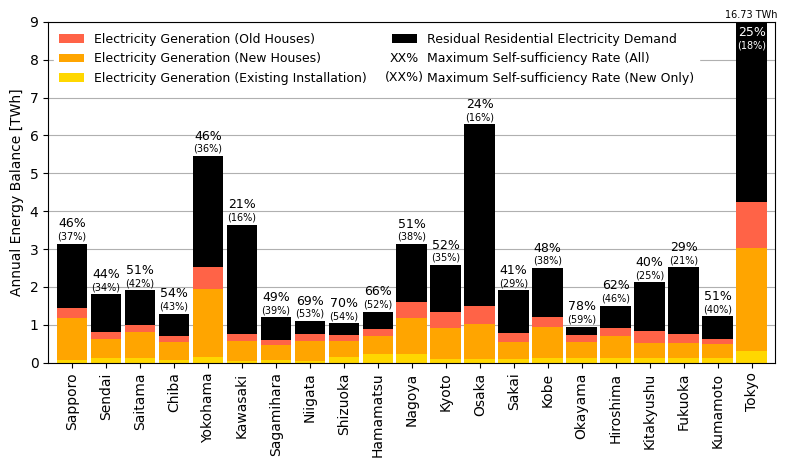

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.tight_layout()

energy_balance = muni_demand.to_frame("demand")

energy_balance.div(1_000_000).plot(
    ax=ax, kind="bar", stacked=False, width=0.9, color="k", position=0.50001
)
colors = ["gold", "orange", "tomato"]
rtpv_gen.div(1_000_000).plot(
    ax=ax, kind="bar", stacked=True, width=0.9, color=colors, position=0.5
)

ax.set_ylim(0, 9)

ax.set_ylabel("Annual Energy Balance [TWh]")
ax.set_xlabel("")

ax.grid(axis="y")
ax.set_axisbelow(True)

# Legends
# Get handles and labels from both axes
handles_ax, labels_ax = ax.get_legend_handles_labels()

# Merge handles and labels
handles = handles_ax[::-1]
labels = labels_ax[::-1]

rename_cols = {
    "cap_old": "Electricity Generation (Old Houses)",
    "cap_new": "Electricity Generation (New Houses)",
    "gen_current": "Electricity Generation (Existing Installation)",
    "demand": "Residual Residential Electricity Demand",
}
labels = [rename_cols.get(l, l) for l in labels]

# Use a dummy Line2D object as a placeholder for the custom text-based handles
handle1 = Line2D([], [], linestyle='None')
handle2 = Line2D([], [], linestyle='None')

# Append the dummy handles and labels
handles.append(handle1)
labels.append('Maximum Self-sufficiency Rate (All)')

handles.append(handle2)
labels.append('Maximum Self-sufficiency Rate (New Only)')


# Specify the handler map where the dummy handles are mapped to the custom handlers
handler_map = {
    handle1: HandlerValue('XX%'), 
    handle2: HandlerValue('(XX%)'),
}

# Create a single legend for both plots
ax.legend(handles, labels, loc="upper left", edgecolor="white", framealpha=1, ncols=2, handler_map=handler_map, fontsize=9)

# annotation
df_temp1 = 100*rtpv_gen.sum(axis=1)/energy_balance['demand']
pene_rate = df_temp1.round(0).astype(int).to_dict()
df_temp2 = 100*rtpv_gen[["gen_current", "cap_new"]].sum(axis=1)/energy_balance['demand']
pene_rate_new = df_temp2.round(0).astype(int).to_dict()

for x, (name, val) in enumerate(energy_balance['demand'].items()):
	y = val/1_000_000
	color = 'k'
	if name == "Tokyo":
		y = 8.2
		color = 'w'
	ax.text(x, y + 0.35, f"{pene_rate.get(name)}%", ha="center", va="bottom", color=color, fontsize=9)
	ax.text(x, y + 0.05, f"({pene_rate_new.get(name)}%)", ha="center", va="bottom", color=color, fontsize=7)

tokyo_dmd = round(energy_balance.loc['Tokyo', 'demand'].item()/1_000_000,2)
ax.text(20, 9.05, f"{tokyo_dmd} TWh", ha="center", va="bottom", color="k", fontsize=7)

savefig(fig, "energy_balance_potential.pdf", dpi=300)

In [16]:
# ============================================================================ #
# Curtailment Rate
# ============================================================================ #

curtailment_rate_df

No Battery               With Battery              Delta         \
                    C  D_new  D_all            C D_new  D_all     C  D_new   
Sapporo          0.00  19.78  30.72          0.0  0.79   3.08  0.00  18.99   
Sendai          -0.00  16.51  28.10         -0.0  0.44   2.04  0.00  16.07   
Saitama         -0.00  26.34  36.65         -0.0  1.66   4.63  0.00  24.68   
Chiba            0.00  25.36  37.11          0.0  1.60   5.02  0.00  23.76   
Yokohama         0.00  17.50  30.10          0.0  0.42   2.39  0.00  17.08   
Kawasaki         0.00   0.06   1.67          0.0 -0.00  -0.00  0.00   0.06   
Sagamihara      -0.00  21.32  32.65         -0.0  0.92   3.04  0.00  20.40   
Niigata         -0.00  36.95  51.64         -0.0  4.36  11.18  0.00  32.59   
Shizuoka         0.01  38.66  52.32          0.0  6.58  13.83  0.01  32.08   
Hamamatsu        0.15  35.72  48.82         -0.0  5.35  11.35  0.15  30.37   
Nagoya          -0.00  17.95  33.47         -0.0  0.73   3.93  0.00  17.22   
Kyoto           -0.00  14.37  33.28         -0.0  0.23   3.23  0.00  14.14   
Osaka            0.00   0.04   2.80          0.0  0.00  -0.00  0.00   0.04   
Sakai            0.00   6.74  20.93          0.0  0.00   0.77  0.00   6.74   
Kobe             0.00  17.17  29.00          0.0  0.36   2.00  0.00  16.81   
Okayama         -0.00  41.24  56.66         -0.0  6.19  14.57  0.00  35.05   
Hiroshima        0.00  29.72  45.46          0.0  2.92   8.40  0.00  26.80   
Kitakyushu      -0.00   5.27  22.23         -0.0 -0.00   1.22  0.00   5.27   
Fukuoka         -0.00   2.34  11.25         -0.0  0.00   0.04  0.00   2.34   
Kumamoto        -0.00  24.86  38.16         -0.0  2.18   6.54  0.00  22.68   
Tokyo           -0.00   0.50   5.73         -0.0 -0.00   0.00  0.00   0.50   

                   
            D_all  
Sapporo     27.64  
Sendai      26.06  
Saitama     32.02  
Chiba       32.09  
Yokohama    27.71  
Kawasaki     1.67  
Sagamihara  29.61  
Niigata     40.46  
Shizuoka    38.49  
Hamamatsu   37.47  
Nagoya      29.54  
Kyoto       30.05  
Osaka        2.80  
Sakai       20.16  
Kobe        27.00  
Okayama     42.09  
Hiroshima   37.06  
Kitakyushu  21.01  
Fukuoka     11.21  
Kumamoto    31.62  
Tokyo        5.73

In [17]:
# ============================================================================ #
# Curtailment Rate sorted by the with-battery, D_all scenario
# ============================================================================ #

curtailment_rate_df.sort_values(by=table_columns[5])

No Battery               With Battery              Delta         \
                    C  D_new  D_all            C D_new  D_all     C  D_new   
Tokyo           -0.00   0.50   5.73         -0.0 -0.00   0.00  0.00   0.50   
Kawasaki         0.00   0.06   1.67          0.0 -0.00  -0.00  0.00   0.06   
Osaka            0.00   0.04   2.80          0.0  0.00  -0.00  0.00   0.04   
Fukuoka         -0.00   2.34  11.25         -0.0  0.00   0.04  0.00   2.34   
Sakai            0.00   6.74  20.93          0.0  0.00   0.77  0.00   6.74   
Kitakyushu      -0.00   5.27  22.23         -0.0 -0.00   1.22  0.00   5.27   
Kobe             0.00  17.17  29.00          0.0  0.36   2.00  0.00  16.81   
Sendai          -0.00  16.51  28.10         -0.0  0.44   2.04  0.00  16.07   
Yokohama         0.00  17.50  30.10          0.0  0.42   2.39  0.00  17.08   
Sagamihara      -0.00  21.32  32.65         -0.0  0.92   3.04  0.00  20.40   
Sapporo          0.00  19.78  30.72          0.0  0.79   3.08  0.00  18.99   
Kyoto           -0.00  14.37  33.28         -0.0  0.23   3.23  0.00  14.14   
Nagoya          -0.00  17.95  33.47         -0.0  0.73   3.93  0.00  17.22   
Saitama         -0.00  26.34  36.65         -0.0  1.66   4.63  0.00  24.68   
Chiba            0.00  25.36  37.11          0.0  1.60   5.02  0.00  23.76   
Kumamoto        -0.00  24.86  38.16         -0.0  2.18   6.54  0.00  22.68   
Hiroshima        0.00  29.72  45.46          0.0  2.92   8.40  0.00  26.80   
Niigata         -0.00  36.95  51.64         -0.0  4.36  11.18  0.00  32.59   
Hamamatsu        0.15  35.72  48.82         -0.0  5.35  11.35  0.15  30.37   
Shizuoka         0.01  38.66  52.32          0.0  6.58  13.83  0.01  32.08   
Okayama         -0.00  41.24  56.66         -0.0  6.19  14.57  0.00  35.05   

                   
            D_all  
Tokyo        5.73  
Kawasaki     1.67  
Osaka        2.80  
Fukuoka     11.21  
Sakai       20.16  
Kitakyushu  21.01  
Kobe        27.00  
Sendai      26.06  
Yokohama    27.71  
Sagamihara  29.61  
Sapporo     27.64  
Kyoto       30.05  
Nagoya      29.54  
Saitama     32.02  
Chiba       32.09  
Kumamoto    31.62  
Hiroshima   37.06  
Niigata     40.46  
Hamamatsu   37.47  
Shizuoka    38.49  
Okayama     42.09

In [18]:
if print_latex:
	latex_temp_df = curtailment_rate_df.copy()
	latex_temp_df = latex_temp_df.applymap(lambda x: f"{0.00:.2f}" if abs(x) < 1e-10 else f"{x:.2f}")
	print(latex_temp_df.to_latex())